# Laboratorio 5 Grupal.
### Nombres:
###          - Aramayo Valdez Joaquin.
###          - Piza Nava Vladimir.
###          - Viza Hoyos Maria Belen.
###          - Mendoza Ovando Carlos Saul.
###          - Solorzano Diego.
### Link Dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_eval_partition.csv
### Link GitHub:


# Punto 2 - Aprendisaje no supervisado

### Importando librerias

In [1]:
import os
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from PIL import Image # type: ignore
import torch # type: ignore
import torchvision.transforms as transforms # type: ignore
from torchvision import models # type: ignore
from sklearn.cluster import KMeans # type: ignore

import pandas as pd # type: ignore
from sklearn.metrics import accuracy_score # type: ignore

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # type: ignore
import seaborn as sns # type: ignore

### Configuraci√≥n y Preprocesamiento de Im√°genes

 Selecciona el dispositivo de procesamiento (GPU o CPU) y carga im√°genes desde una carpeta, convirti√©ndolas a RGB y redimension√°ndolas, con un l√≠mite de cantidad definido.

In [2]:
# Configuraci√≥n de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar las im√°genes
def load_images(image_folder, image_size=(128, 128), max_images=1000):
    image_paths = []
    images = []
    for filename in os.listdir(image_folder):
        if len(images) >= max_images:  # Limitar a 1000 im√°genes
            break
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            image_paths.append(img_path)
            images.append(img)
    return images, image_paths


### Normalizaci√≥n de Im√°genes

Aplica una transformaci√≥n para convertir im√°genes a tensores y normalizarlas con medias y desviaciones est√°ndar predefinidas, ajust√°ndolas a un formato adecuado para modelos de visi√≥n.

In [3]:

# Normalizar las im√°genes
def normalize_images(images):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return [transform(img) for img in images]  # Cambiar a lista de tensores


### Extracci√≥n de Caracter√≠sticas y Clustering de Im√°genes

Utiliza un modelo ResNet50 preentrenado para extraer caracter√≠sticas de las im√°genes procesadas en el dispositivo configurado (CPU o GPU), y agrupa estas caracter√≠sticas en clusters mediante K-means, devolviendo las etiquetas de cluster y el modelo ajustado.

In [4]:

# Extraer caracter√≠sticas de las im√°genes utilizando un modelo preentrenado
def extract_features(images):
    model = models.resnet50(weights='DEFAULT').to(device)
    model.eval()
    with torch.no_grad():
        # Asegurarse de apilar correctamente los tensores
        features = model(torch.stack(images).to(device))
    return features.cpu().numpy()

# Realizar clustering
def perform_clustering(features, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans


### Identificaci√≥n de Im√°genes Representativas y Visualizaci√≥n de Clusters:

Encuentra las im√°genes m√°s cercanas a los centroides de cada cluster y las almacena. Luego, muestra las im√°genes representativas y visualiza los clusters en un gr√°fico 2D, destacando los centroides en rojo.

In [5]:
# Encontrar im√°genes representativas de cada cluster
def find_representative_images(features, cluster_labels, image_paths, kmeans):
    representative_images = {i: [] for i in range(kmeans.n_clusters)}
    
    for cluster in range(kmeans.n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_features = features[cluster_indices]
        
        # Calcular distancias al centroide
        distances = np.linalg.norm(cluster_features - kmeans.cluster_centers_[cluster], axis=1)

        # Obtener el √≠ndice de la imagen m√°s cercana al centroide
        closest_index = cluster_indices[np.argmin(distances)]
        representative_images[cluster].append(image_paths[closest_index])
    
    return representative_images

# Mostrar im√°genes
def show_images(image_paths, n_cols=5):
    n_images = len(image_paths)
    n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    plt.figure(figsize=(15, n_rows * 5))
    
    for idx, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {idx + 1}')
    
    plt.tight_layout()
    plt.show()

# Visualizar clusters
def plot_clusters(features, cluster_labels, kmeans):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, 0], features[:, 1], c=cluster_labels, cmap='viridis', marker='o')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200)  # Centroides
    plt.title('Clusters Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

### C√≥digo Principal para Procesamiento de Im√°genes

Carga im√°genes desde una carpeta, las normaliza, extrae caracter√≠sticas utilizando un modelo preentrenado, realiza clustering, visualiza los clusters y encuentra las im√°genes m√°s representativas para cada cluster, mostrando finalmente estas im√°genes representativas.

Total de im√°genes cargadas: 1000
Extrayendo caracter√≠sticas...
Realizando clustering...


Cluster 0 - Imagen m√°s representativa:


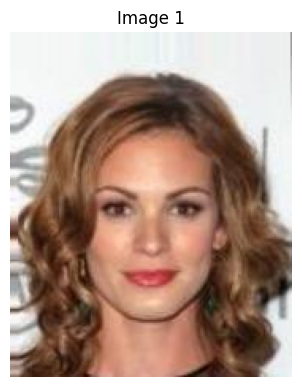

Cluster 1 - Imagen m√°s representativa:


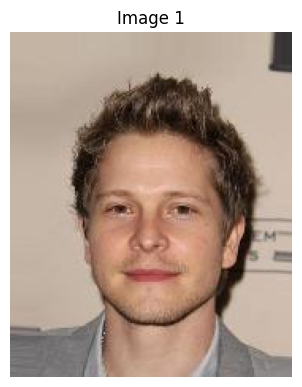

In [6]:
# C√≥digo principal
if __name__ == "__main__":
    # Cargar im√°genes
    image_folder = 'img_align_celeba/'  
    images, image_paths = load_images(image_folder)
    print(f'Total de im√°genes cargadas: {len(images)}')

    # Normalizar im√°genes
    normalized_images = normalize_images(images)

    # Extraer caracter√≠sticas
    print('Extrayendo caracter√≠sticas...')
    features = extract_features(normalized_images)
   # Realizar clustering
    print('Realizando clustering...')
    cluster_labels, kmeans = perform_clustering(features, n_clusters=2)

    # Visualizar clusters
    plot_clusters(features, cluster_labels, kmeans)

    # Encontrar im√°genes representativas
    representative_images = find_representative_images(features, cluster_labels, image_paths, kmeans)

    # Mostrar im√°genes representativas
    for cluster, img_paths in representative_images.items():
        print(f'Cluster {cluster} - Imagen m√°s representativa:')
        show_images(img_paths)

### Evaluaci√≥n de Clasificaci√≥n de G√©nero

Clase que eval√∫a los resultados de clustering en funci√≥n del g√©nero. Permite asignar etiquetas de g√©nero a los clusters, calcular m√©tricas de evaluaci√≥n (exactitud, matriz de confusi√≥n), visualizar la distribuci√≥n de predicciones y mostrar ejemplos de im√°genes por cluster. Adem√°s, incluye m√©todos para predecir el g√©nero de una imagen espec√≠fica y mostrar predicciones aleatorias.

In [7]:

class GenderClassificationEvaluator:
    def __init__(self, cluster_labels, image_paths, kmeans):
        self.cluster_labels = cluster_labels
        self.image_paths = image_paths
        self.kmeans = kmeans
        self.labels_map = {}  # Mapeo de cluster a g√©nero
        self.predicted_labels = None
        
    def assign_gender_to_clusters(self, cluster_0_gender='hombre'):
        """
        Asignar g√©nero a cada cluster despu√©s de la inspecci√≥n visual.
        cluster_0_gender: 'hombre' o 'mujer' - el g√©nero que representa el cluster 0.
        """
        if cluster_0_gender.lower() == 'hombre':
            self.labels_map = {0: 'Hombre', 1: 'Mujer'}
        else:
            self.labels_map = {0: 'Mujer', 1: 'Hombre'}
        
        # Convertir cluster_labels a etiquetas de g√©nero
        self.predicted_labels = np.array([self.labels_map[label] for label in self.cluster_labels])
        
    def evaluate_clusters(self, true_labels=None):
        """
        Evaluar los clusters y mostrar m√©tricas.
        true_labels: etiquetas verdaderas si est√°n disponibles.
        """
        if true_labels is not None:
            # Calcular m√©tricas
            accuracy = accuracy_score(true_labels, self.predicted_labels)
            report = classification_report(true_labels, self.predicted_labels)
            conf_matrix = confusion_matrix(true_labels, self.predicted_labels)
            
            # Visualizar resultados
            self._plot_evaluation_metrics(accuracy, conf_matrix)
            print("\nReporte de Clasificaci√≥n:")
            print(report)
        
        # Mostrar distribuci√≥n de clusters
        self._plot_cluster_distribution()
    
    def _plot_evaluation_metrics(self, accuracy, conf_matrix):
        """Visualizar m√©tricas de evaluaci√≥n."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Matriz de confusi√≥n
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(self.labels_map.values()),
                    yticklabels=list(self.labels_map.values()), ax=ax1)
        ax1.set_title(f'Matriz de Confusi√≥n\nAccuracy: {accuracy:.2%}')
        ax1.set_xlabel('Predicci√≥n')
        ax1.set_ylabel('Valor Real')
        
        # Distribuci√≥n de predicciones
        counts = np.bincount(self.cluster_labels)
        ax2.bar(list(self.labels_map.values()), counts)
        ax2.set_title('Distribuci√≥n de Predicciones')
        ax2.set_ylabel('Cantidad de Im√°genes')
        
        plt.tight_layout()
        plt.show()
    
    def _plot_cluster_distribution(self):
        """Visualizar distribuci√≥n de clusters."""
        unique, counts = np.unique(self.predicted_labels, return_counts=True)
        plt.figure(figsize=(8, 8))
        plt.pie(counts, labels=[f'{label}\n({count:,})' for label, count in zip(unique, counts)],
                autopct='%1.1f%%', startangle=90)
        plt.title('Distribuci√≥n de G√©nero en el Dataset')
        plt.axis('equal')
        plt.show()
    
    def show_cluster_examples(self, examples_per_cluster=5):
        """Mostrar ejemplos de cada cluster."""
        for cluster in range(self.kmeans.n_clusters):
            # Obtener √≠ndices de im√°genes para este cluster
            cluster_indices = np.where(self.cluster_labels == cluster)[0]
            
            # Aseg√∫rate de que haya ejemplos disponibles
            if len(cluster_indices) == 0:
                print(f"No hay ejemplos en el cluster {cluster}.")
                continue
            
            # Seleccionar ejemplos aleatorios
            sample_indices = np.random.choice(cluster_indices, 
                                               size=min(examples_per_cluster, len(cluster_indices)), 
                                               replace=False)
            
            # Mostrar im√°genes
            plt.figure(figsize=(20, 4))
            for idx, img_idx in enumerate(sample_indices, 1):
                img = Image.open(self.image_paths[img_idx])
                plt.subplot(1, examples_per_cluster, idx)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'{self.labels_map[cluster]}')  # Mostrar el g√©nero correcto seg√∫n el cluster
            
            plt.suptitle(f'Ejemplos de Cluster: {self.labels_map[cluster]}')
            plt.show()
    
    def predict_gender(self, image_path):
        """Predecir g√©nero para una imagen espec√≠fica."""
        # Procesar la imagen igual que en el entrenamiento
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))  # Usar el mismo tama√±o que en el entrenamiento
        
        # Mostrar la imagen y su predicci√≥n
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        
        # Obtener √≠ndice en image_paths
        try:
            idx = self.image_paths.index(image_path)
            prediction = self.predicted_labels[idx]
            plt.title(f'Predicci√≥n: {prediction}')
        except ValueError:
            plt.title('Imagen no encontrada en el dataset')
        
        plt.axis('off')
        plt.show()
        
    def show_random_prediction(self):
        """Mostrar una predicci√≥n aleatoria."""
        idx = np.random.choice(len(self.image_paths))  # Seleccionar un √≠ndice aleatorio
        img = Image.open(self.image_paths[idx])
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicci√≥n: {self.predicted_labels[idx]}')
        
        plt.show()


### Uso de la Clase de Evaluaci√≥n de G√©nero

Este fragmento de c√≥digo demuestra c√≥mo utilizar la clase GenderClassificationEvaluator para asignar etiquetas de g√©nero a los clusters despu√©s de realizar un clustering, evaluar los resultados obtenidos, mostrar ejemplos de im√°genes de cada cluster y hacer una predicci√≥n aleatoria sobre una imagen del conjunto de datos.

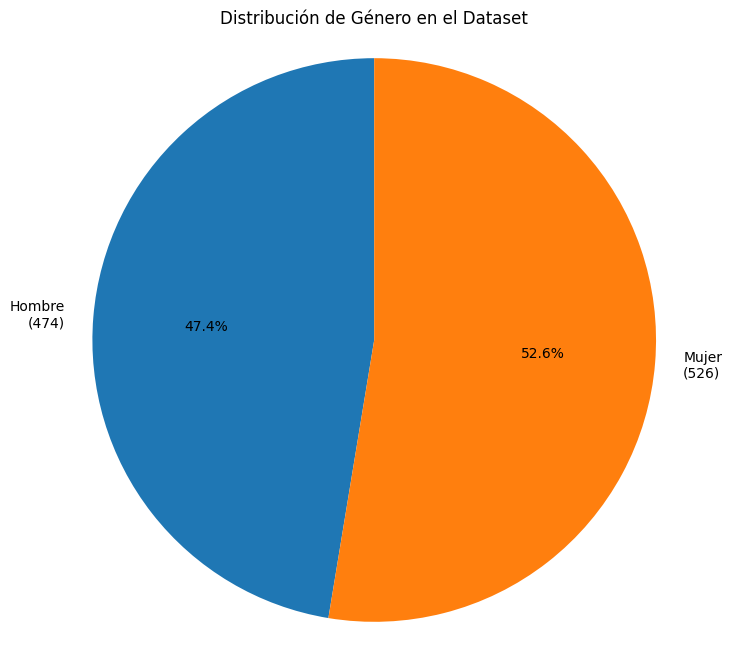

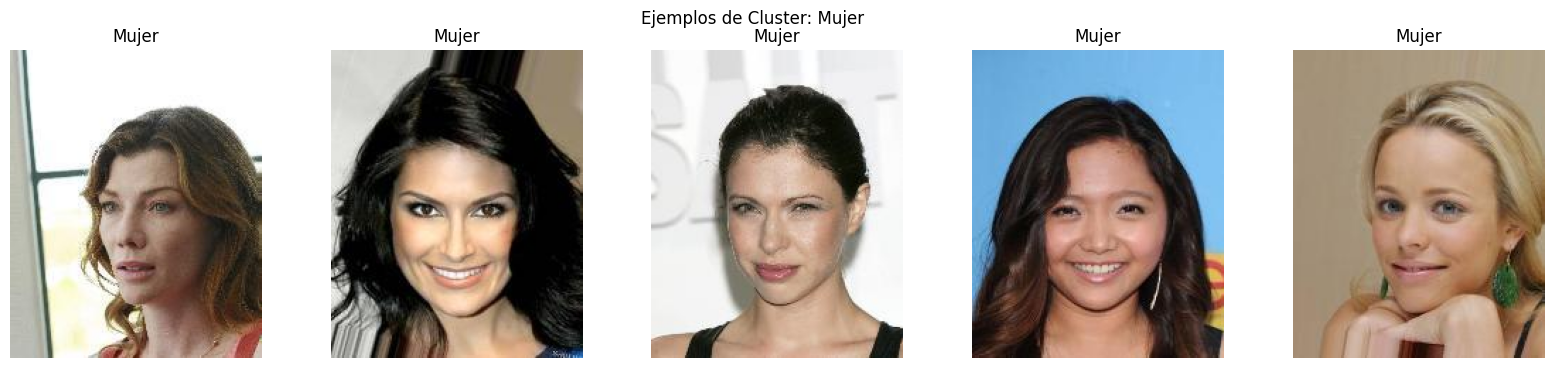

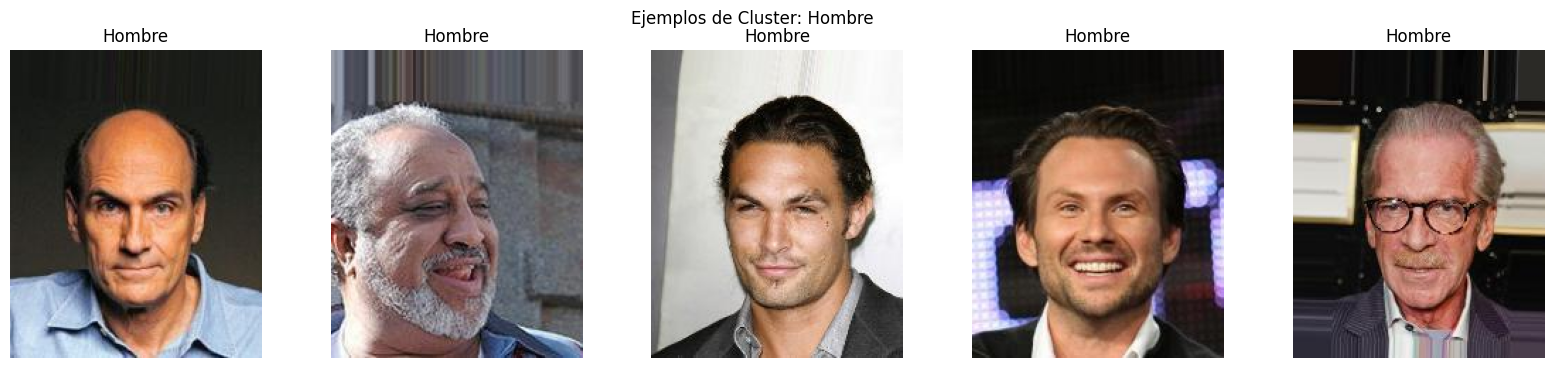

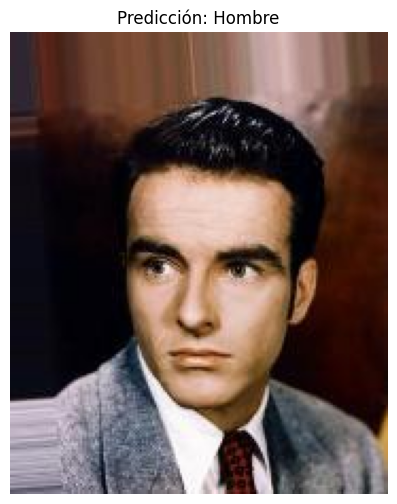

In [8]:
# Crear el evaluador
evaluator = GenderClassificationEvaluator(cluster_labels, image_paths, kmeans)

# Asignar g√©nero a los clusters despu√©s de inspecci√≥n visual
# Cambiar 'hombre' a 'mujer' si el cluster 0 es 'mujer'
# Revisa las im√°genes y aseg√∫rate de que las etiquetas se asignen correctamente
evaluator.assign_gender_to_clusters(cluster_0_gender='mujer')  # Cambiar a 'mujer' o 'hombre' seg√∫n corresponda

# Evaluar resultados
evaluator.evaluate_clusters()

# Mostrar ejemplos de cada cluster
evaluator.show_cluster_examples()

# Mostrar una predicci√≥n aleatoria
evaluator.show_random_prediction()

### Carga y Evaluaci√≥n con Etiquetas Verdaderas:

Este c√≥digo carga las etiquetas verdaderas de g√©nero desde un archivo CSV, limitando la carga a las primeras 1000 muestras. Luego, crea una instancia de GenderClassificationEvaluator, asigna etiquetas de g√©nero a los clusters, y eval√∫a la precisi√≥n del modelo al comparar las etiquetas verdaderas con las predicciones, mostrando el porcentaje de precisi√≥n si las longitudes de ambas listas coinciden.

In [9]:


# Cargar etiquetas verdaderas desde el archivo CSV, pero solo las primeras 1000
def load_true_labels(csv_file, num_samples=1000):
    df = pd.read_csv(csv_file)
    # Seleccionamos solo las primeras 1000 filas si es necesario
    df = df.iloc[:num_samples]
    # Convertimos la columna 'Male' a etiquetas de g√©nero
    true_labels = df['Male'].apply(lambda x: 'Hombre' if x == 1 else 'Mujer').values
    return true_labels

# Cargar las etiquetas verdaderas limitadas a 1000
true_labels = load_true_labels('list_attr_celeba.csv', num_samples=1000)

# Crear el evaluador
evaluator = GenderClassificationEvaluator(cluster_labels, image_paths, kmeans)

# Asignar g√©nero a los clusters despu√©s de la inspecci√≥n visual
evaluator.assign_gender_to_clusters(cluster_0_gender='mujer')  # Ajusta seg√∫n la inspecci√≥n

# Evaluar resultados y calcular la precisi√≥n si las longitudes coinciden
if len(true_labels) == len(evaluator.predicted_labels):
    accuracy = accuracy_score(true_labels, evaluator.predicted_labels)
    print(f"Precisi√≥n del modelo: {accuracy * 100:.2f}%")
else:
    print("Error: Las longitudes de las etiquetas verdaderas y predichas no coinciden.")


Precisi√≥n del modelo: 91.60%


# Aprendisaje activo

### Clase ActiveLearningGenderClassifier

Esta clase implementa un clasificador de g√©nero con un enfoque de aprendizaje activo, utilizando clustering para agrupar caracter√≠sticas de im√°genes y ajustar el modelo en funci√≥n de etiquetas verdaderas y correcciones. Permite evaluar la confianza en las predicciones y realizar reentrenamientos con correcciones.

In [10]:
class ActiveLearningGenderClassifier:
    def __init__(self, features, image_paths, n_clusters=2):
        self.features = features
        self.image_paths = image_paths
        self.n_clusters = n_clusters
        self.kmeans = None
        self.cluster_labels = None
        self.predicted_labels = None
        self.confidence_scores = None
        self.true_labels = None
        self.labels_map = {}
        
    def initial_clustering(self):
        """
        Realizar el clustering inicial y calcular la confianza
        """
        print("Realizando clustering inicial...")
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.cluster_labels = self.kmeans.fit_predict(self.features)
        
        # Calcular distancias a los centroides para la confianza
        distances = np.zeros((len(self.features), self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.linalg.norm(self.features - self.kmeans.cluster_centers_[i], axis=1)
        
        # Calcular scores de confianza
        sorted_distances = np.sort(distances, axis=1)
        self.confidence_scores = 1 - (sorted_distances[:, 0] / (sorted_distances[:, 1] + 1e-10))
        
        return self.cluster_labels
    
    def load_true_labels(self, csv_path):
        """
        Cargar las etiquetas verdaderas del dataset CelebA
        """
        print("Cargando etiquetas verdaderas...")
        df = pd.read_csv(csv_path)
        
        # Convertir nombres de archivo a solo el nombre base
        current_filenames = [os.path.basename(path) for path in self.image_paths]
        
        # Filtrar y obtener las etiquetas correspondientes
        matching_labels = []
        for filename in current_filenames:
            if filename in df['image_id'].values:
                label = df[df['image_id'] == filename]['Male'].iloc[0]
                matching_labels.append('Hombre' if label == 1 else 'Mujer')
            else:
                matching_labels.append(None)
                
        self.true_labels = np.array(matching_labels)
        return self.true_labels
    
    def assign_clusters(self):
        """
        Asignar etiquetas de g√©nero a los clusters basado en las etiquetas verdaderas
        """
        if self.true_labels is None:
            raise ValueError("Debe cargar las etiquetas verdaderas primero")
            
        # Contar g√©nero mayoritario en cada cluster
        cluster_0_males = sum(1 for i in range(len(self.cluster_labels)) 
                            if self.cluster_labels[i] == 0 and self.true_labels[i] == 'Hombre')
        cluster_0_females = sum(1 for i in range(len(self.cluster_labels)) 
                              if self.cluster_labels[i] == 0 and self.true_labels[i] == 'Mujer')
        
        # Asignar etiquetas basado en la mayor√≠a
        if cluster_0_males > cluster_0_females:
            self.labels_map = {0: 'Hombre', 1: 'Mujer'}
        else:
            self.labels_map = {0: 'Mujer', 1: 'Hombre'}
            
        # Convertir cluster_labels a etiquetas de g√©nero
        self.predicted_labels = np.array([self.labels_map[label] for label in self.cluster_labels])
        
        # Calcular y mostrar accuracy inicial
        accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        print(f"\nüéØ Precisi√≥n inicial del modelo: {accuracy:.2%}")
        
        return self.predicted_labels
    
    def show_low_confidence_predictions(self, n_samples=5):
        """
        Mostrar las predicciones con menor confianza
        """
        print("\nMostrando predicciones con menor confianza...")
        low_conf_indices = np.argsort(self.confidence_scores)[:n_samples]
        
        plt.figure(figsize=(20, 4))
        for idx, img_idx in enumerate(low_conf_indices, 1):
            img = Image.open(self.image_paths[img_idx])
            plt.subplot(1, n_samples, idx)
            plt.imshow(img)
            plt.axis('off')
            title = f'Pred: {self.predicted_labels[img_idx]}\n'
            title += f'Real: {self.true_labels[img_idx]}\n'
            title += f'Conf: {self.confidence_scores[img_idx]:.2f}'
            plt.title(title)
        
        plt.suptitle('Im√°genes con Menor Confianza en la Predicci√≥n')
        plt.show()
        return low_conf_indices
    
    def retrain_with_corrections(self, correction_indices):
        """
        Reentrenar el modelo usando las etiquetas corregidas
        """
        print("\nReentrenando el modelo con correcciones...")
        
        # Crear nueva matriz de caracter√≠sticas con m√°s peso para las muestras corregidas
        weighted_features = np.copy(self.features)
        for idx in correction_indices:
            weighted_features = np.vstack([weighted_features, self.features[idx]])
        
        # Reentrenar K-means
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        new_cluster_labels = self.kmeans.fit_predict(weighted_features)
        self.cluster_labels = new_cluster_labels[:len(self.features)]
        
        # Recalcular confianza
        distances = np.zeros((len(self.features), self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.linalg.norm(self.features - self.kmeans.cluster_centers_[i], axis=1)
        
        sorted_distances = np.sort(distances, axis=1)
        self.confidence_scores = 1 - (sorted_distances[:, 0] / (sorted_distances[:, 1] + 1e-10))
        
        # Reasignar clusters
        self.assign_clusters()
        
        # Calcular y mostrar nueva accuracy
        new_accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        print(f"\nüéØ Precisi√≥n despu√©s del reentrenamiento: {new_accuracy:.2%}")
        
        return new_accuracy
    
    def show_random_prediction(self):
        """
        Mostrar una predicci√≥n aleatoria
        """
        print("\nMostrando predicci√≥n aleatoria...")
        idx = np.random.choice(len(self.image_paths))
        img = Image.open(self.image_paths[idx])
        
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        title = f'Predicci√≥n: {self.predicted_labels[idx]}\n'
        title += f'Etiqueta Real: {self.true_labels[idx]}\n'
        title += f'Confianza: {self.confidence_scores[idx]:.2f}'
        plt.title(title)
        plt.show()


### Funci√≥n implement_active_learning

 Esta funci√≥n implementa el proceso completo de aprendizaje activo para clasificar el g√©nero de im√°genes. Utiliza la clase ActiveLearningGenderClassifier para realizar clustering, cargar etiquetas verdaderas, asignar clusters, evaluar la precisi√≥n, mostrar ejemplos con baja confianza y reentrenar el modelo con correcciones.

In [11]:
def implement_active_learning(features, image_paths):
    """
    Implementar el proceso completo de active learning
    """
    # Crear el clasificador
    classifier = ActiveLearningGenderClassifier(features, image_paths)
    
    # Realizar clustering inicial
    classifier.initial_clustering()
    
    # Cargar etiquetas verdaderas
    classifier.load_true_labels('list_attr_celeba.csv')
    
    # Asignar clusters y mostrar accuracy inicial
    classifier.assign_clusters()
    
    # Mostrar ejemplos de baja confianza
    low_conf_indices = classifier.show_low_confidence_predictions(n_samples=5)
    
    # Reentrenar con las correcciones
    final_accuracy = classifier.retrain_with_corrections(low_conf_indices)
    
    # Mostrar una predicci√≥n aleatoria
    classifier.show_random_prediction()
    
    return classifier

### C√≥digo Principal

El siguiente c√≥digo principal se encarga de cargar im√°genes, normalizarlas, extraer sus caracter√≠sticas y luego implementar el aprendizaje activo para clasificar el g√©nero de las im√°genes utilizando la clase ActiveLearningGenderClassifier

Total de im√°genes cargadas: 1000
Extrayendo caracter√≠sticas...
Realizando clustering inicial...
Cargando etiquetas verdaderas...

üéØ Precisi√≥n inicial del modelo: 91.20%

Mostrando predicciones con menor confianza...


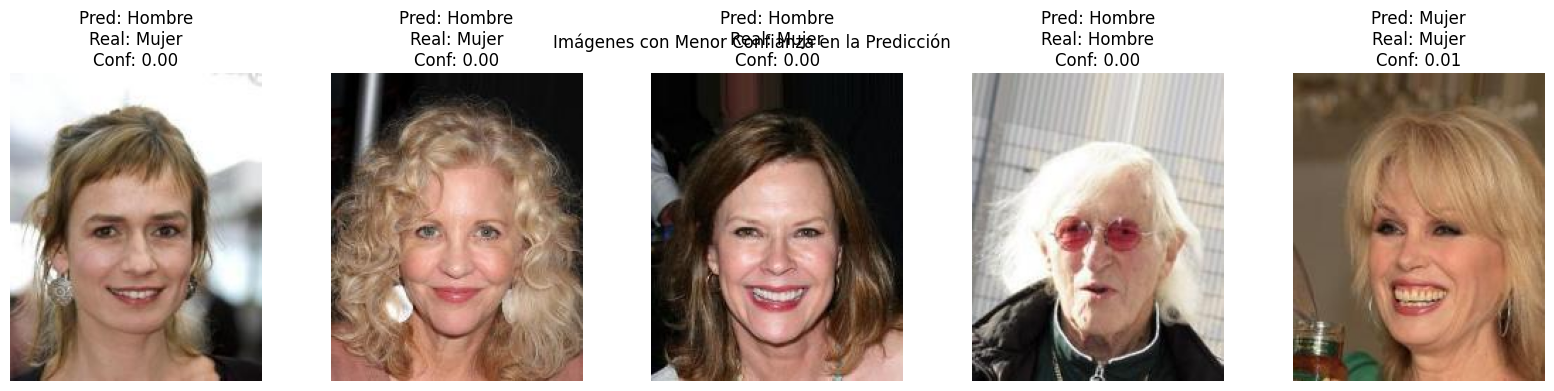


Reentrenando el modelo con correcciones...

üéØ Precisi√≥n inicial del modelo: 91.50%

üéØ Precisi√≥n despu√©s del reentrenamiento: 91.50%

Mostrando predicci√≥n aleatoria...


In [12]:
# C√≥digo principal
if __name__ == "__main__":
    # Cargar im√°genes
    image_folder = 'img_align_celeba/'  # Ajusta esta ruta
    images, image_paths = load_images(image_folder)
    print(f'Total de im√°genes cargadas: {len(images)}')

    # Normalizar im√°genes
    normalized_images = normalize_images(images)

    # Extraer caracter√≠sticas
    print('Extrayendo caracter√≠sticas...')
    features = extract_features(normalized_images)

    # Implementar active learning
    classifier = implement_active_learning(features, image_paths)